In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

pd.set_option('display.max_columns', None)

%matplotlib inline

In [33]:
data_dir_path = "../data/fraud_oracle.csv"
df = pd.read_csv(data_dir_path, dtype=object)
print(df.shape)
df.head()

(15420, 33)


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [34]:
#preprocessing
df["Month"] = pd.to_datetime(df["Month"], format="%b").dt.strftime("%m") + df["Month"]

numeric_cols = [
    "Age",
    "Deductible",
    "DriverRating",
    "RepNumber"
    ]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col])

print(df.shape)
df.head()

(15420, 33)


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,12Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,01Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,10Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,06Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,01Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [35]:
pd.concat([
    df["FraudFound_P"].value_counts().rename("fraud_counts"),
    df["FraudFound_P"].value_counts(normalize=True).rename("fraud_counts_prcnt")],
    axis=1)

,fraud_counts,fraud_counts_prcnt
0,14497,0.940143
1,923,0.059857


In [39]:
def generate_dist_fraud(df, fraud_col, dim_col, flatten=False):
    dist_df_flat = df\
        .groupby([dim_col, fraud_col])\
        .size()\
        .rename("counts")
    dist_df_flat = pd.concat([
        dist_df_flat,
        dist_df_flat.groupby(level=dim_col)\
            .apply(lambda sr: sr/sr.sum())\
            .rename("counts_prcnt")], axis=1)\
        .unstack(level=fraud_col)\
        .fillna(0)
        
    if flatten:
        return dist_df_flat\
            .stack()\
            .reset_index()
    else:
        return dist_df_flat
    
def visualize_fraud_dist(dist_df_flat, fraud_col, dim_col):

    fig, ax = plt.subplots(figsize=(30, 5))
    barplot = sn.barplot(
        x=dim_col, 
        y="counts_prcnt", 
        hue=fraud_col, 
        data=dist_df_flat)
    
    ax.xaxis.label.set_size(25)
    ax.yaxis.label.set_size(25)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_ylim(0, 1)

    xticklabels = \
        [xticklabel.get_text() for xticklabel \
         in barplot.get_xticklabels()]

    for container in barplot.containers:
        fraud_col_val = container.get_label()
        labels = dist_df_flat\
            .set_index([dim_col, fraud_col])\
            .loc[(xticklabels, fraud_col_val), "counts"]\
            .astype(int)
        ax.bar_label(container, labels=labels, size=13)
        
    plt.show()

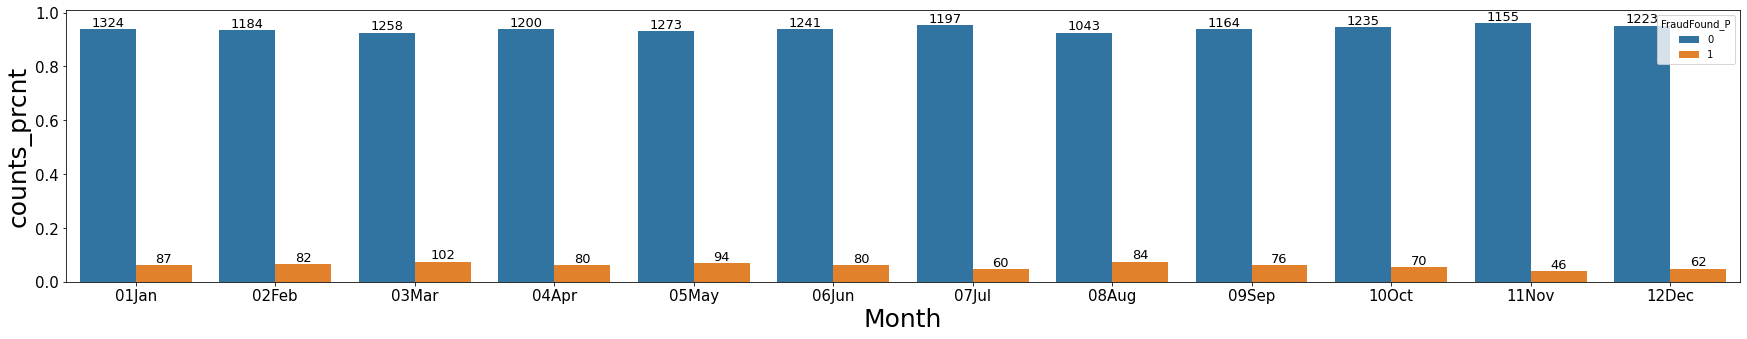

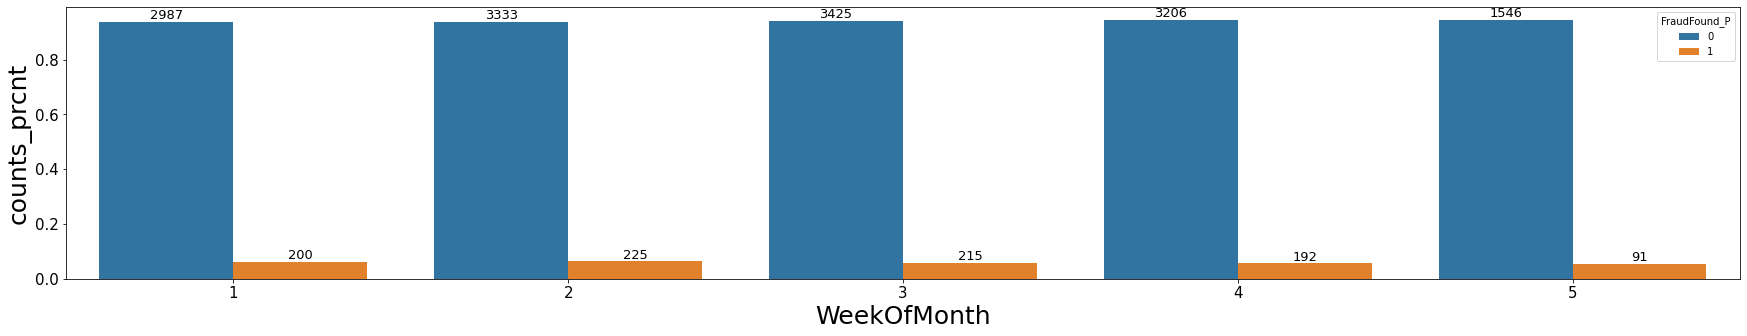

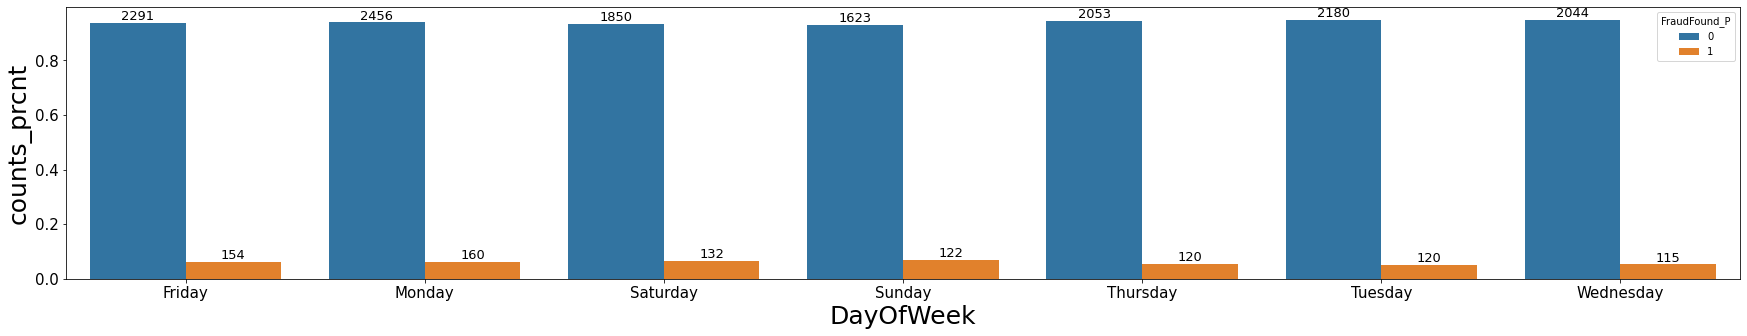

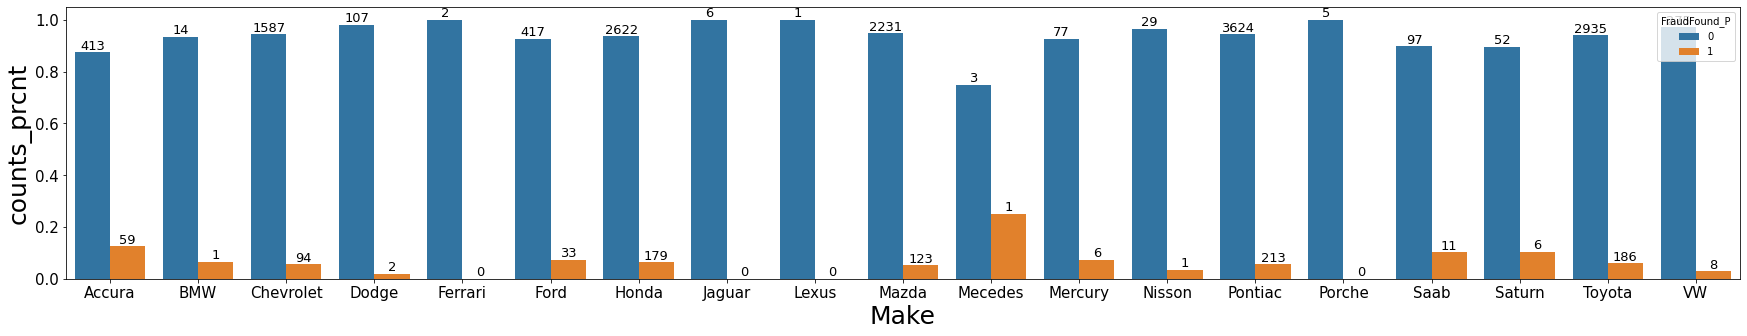

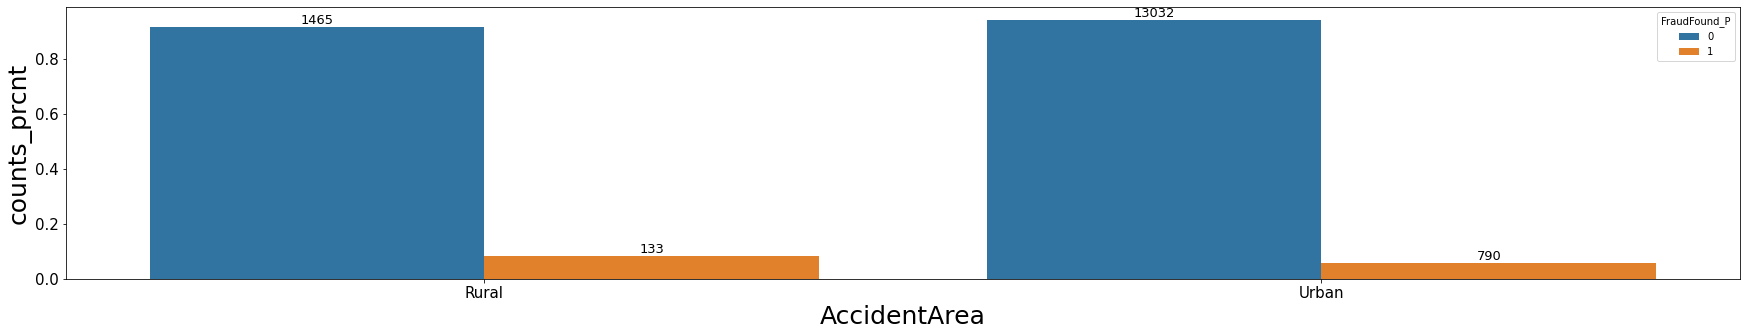

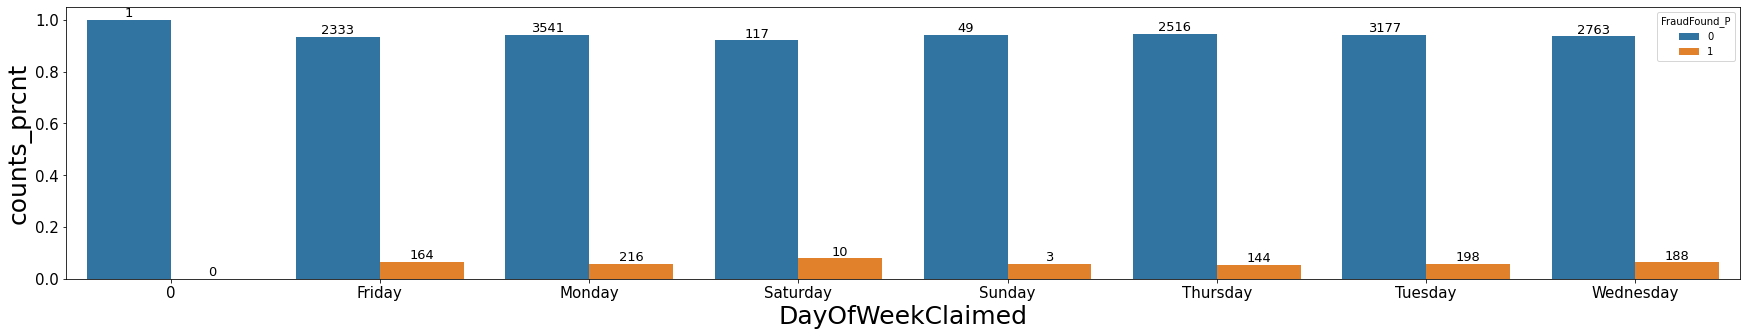

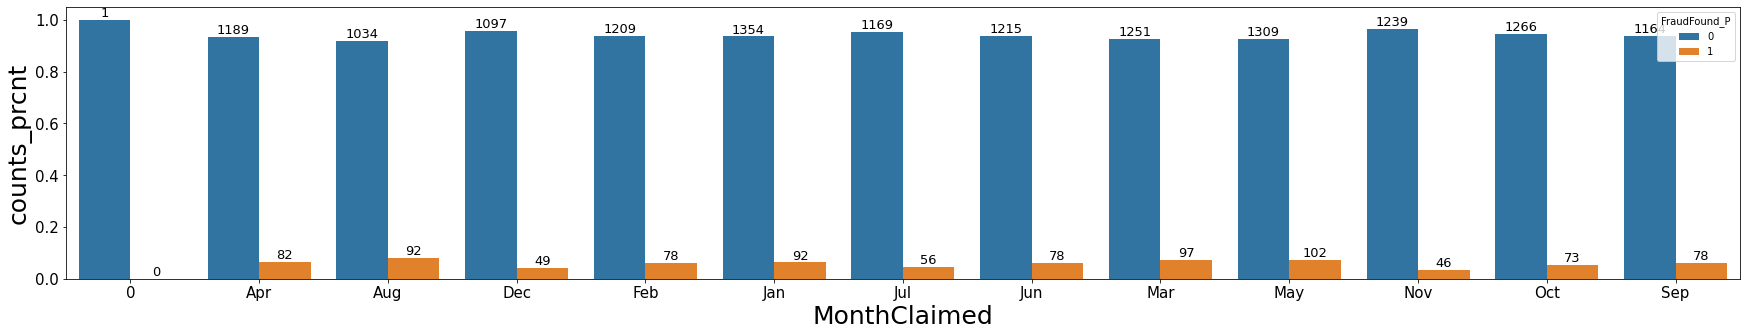

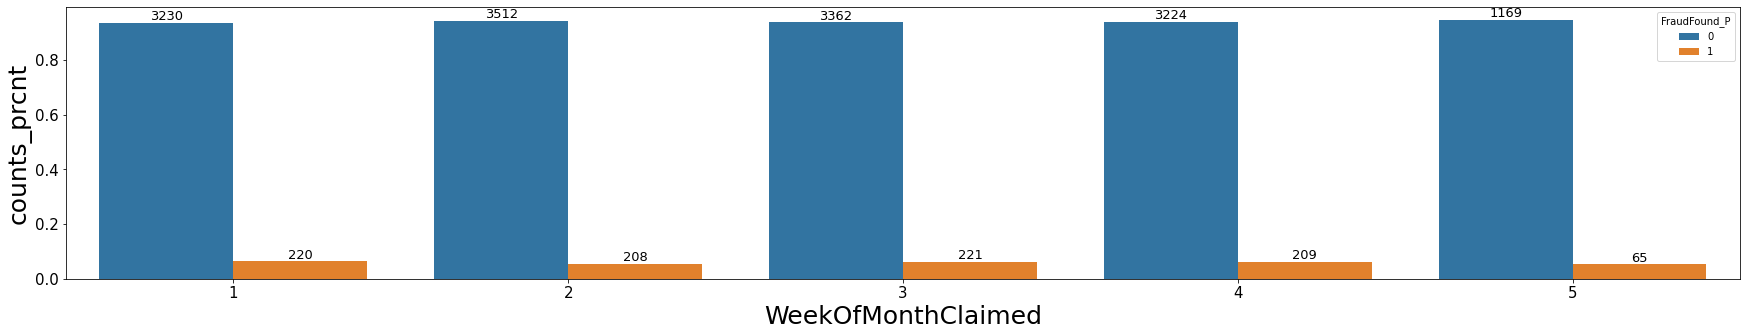

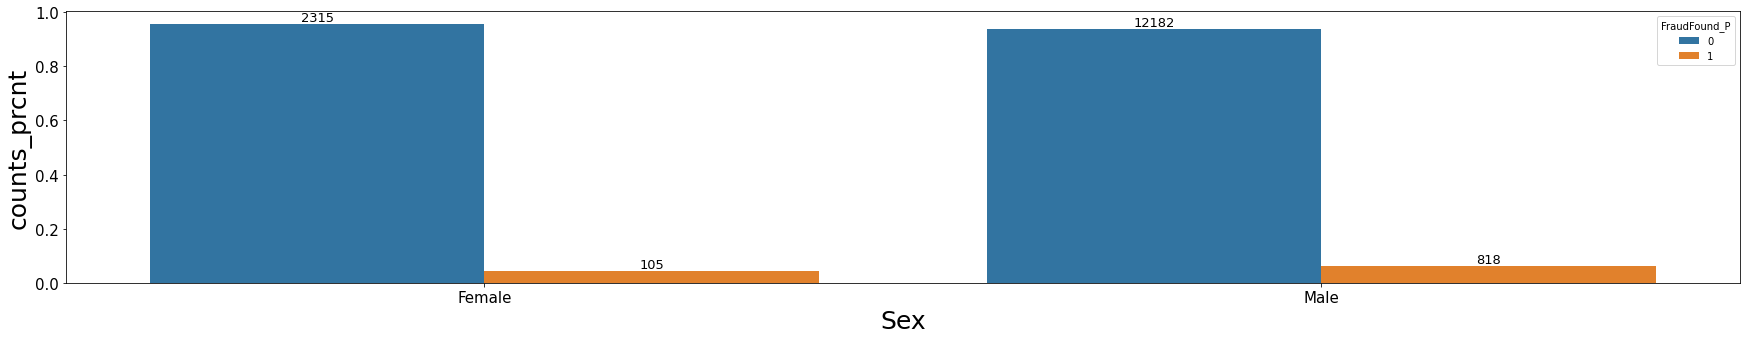

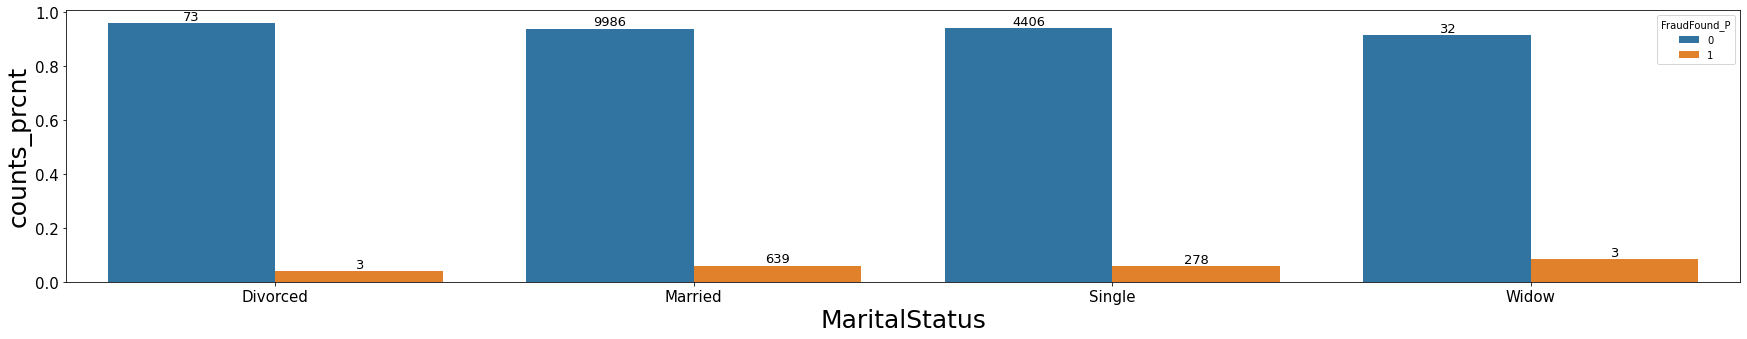

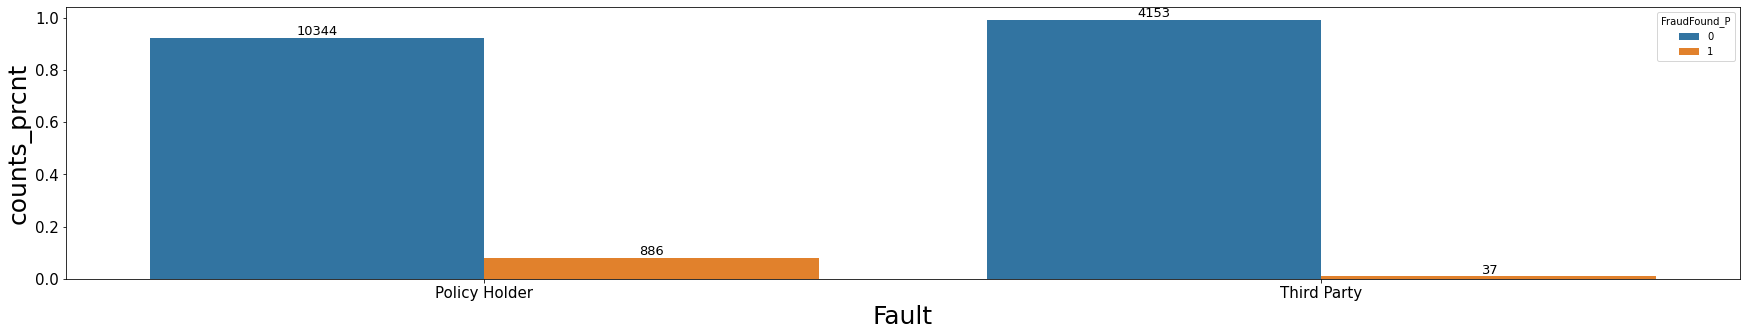

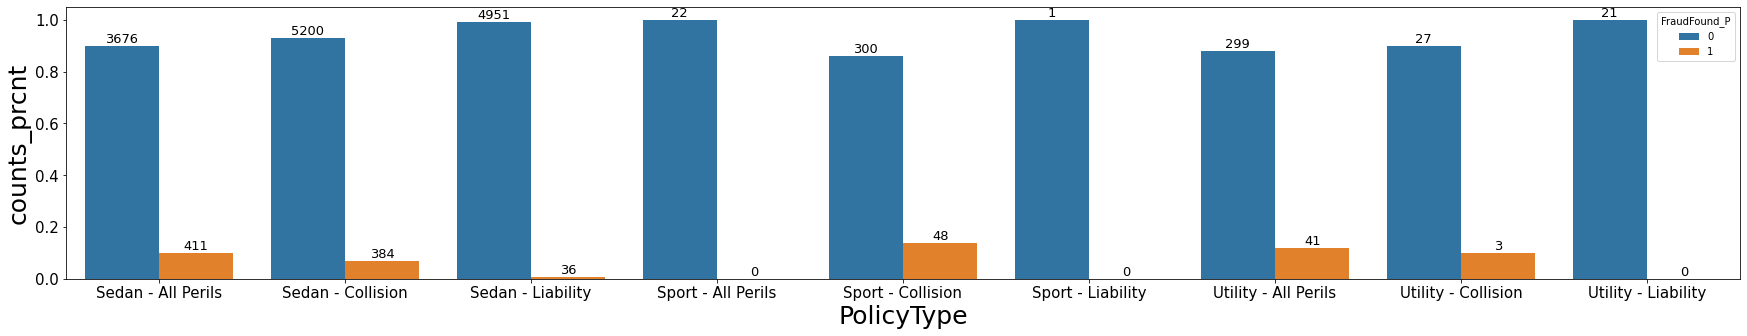

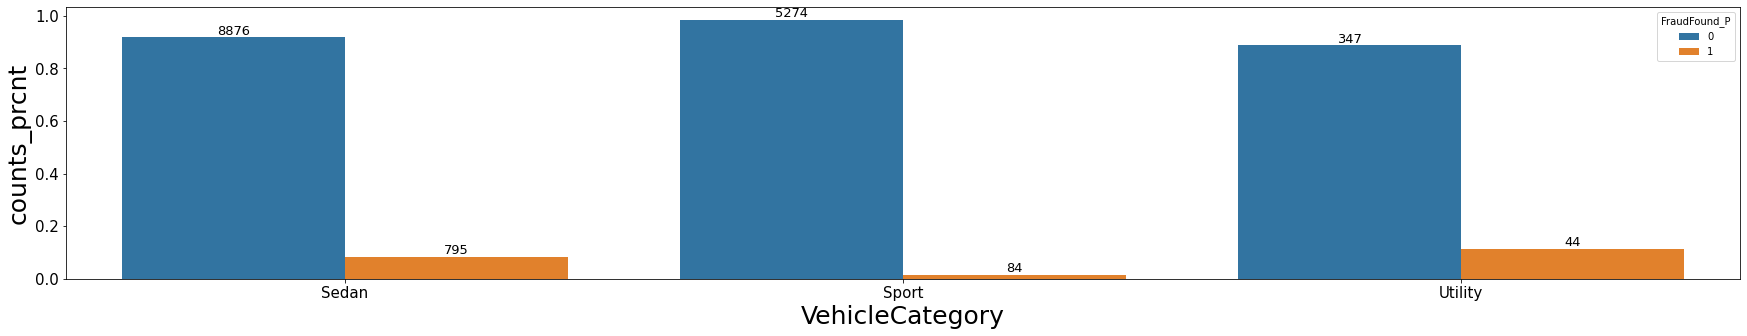

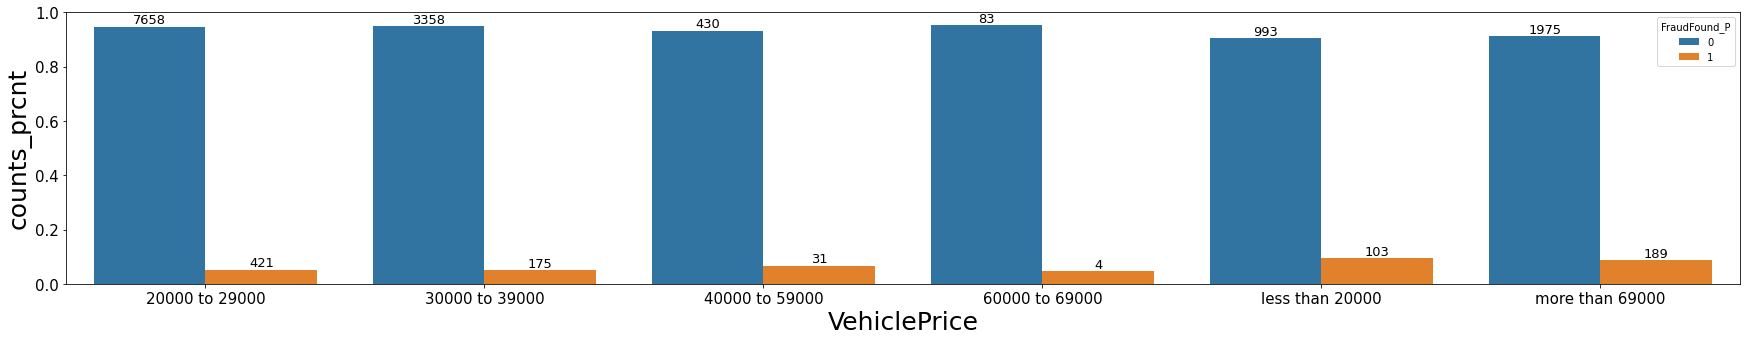

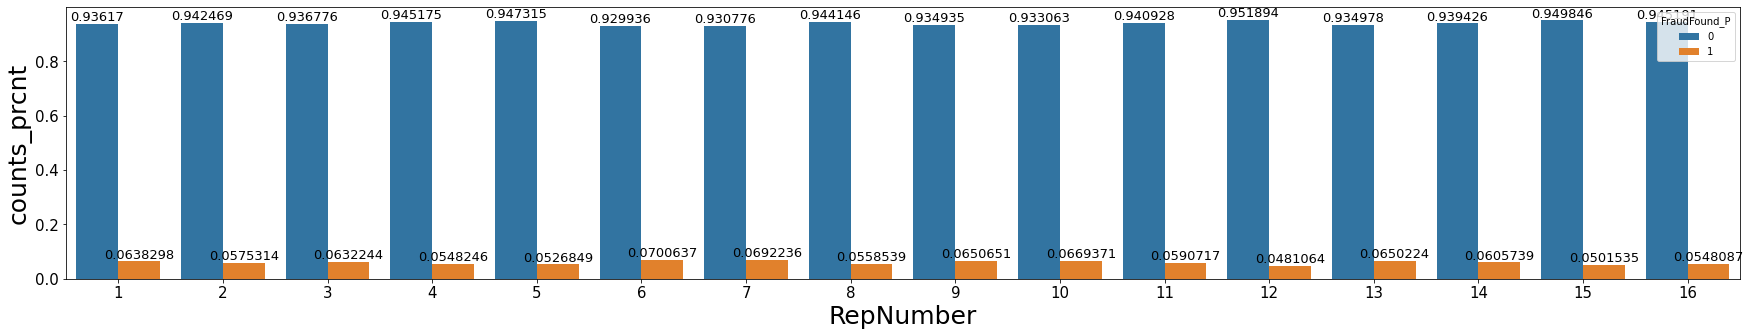

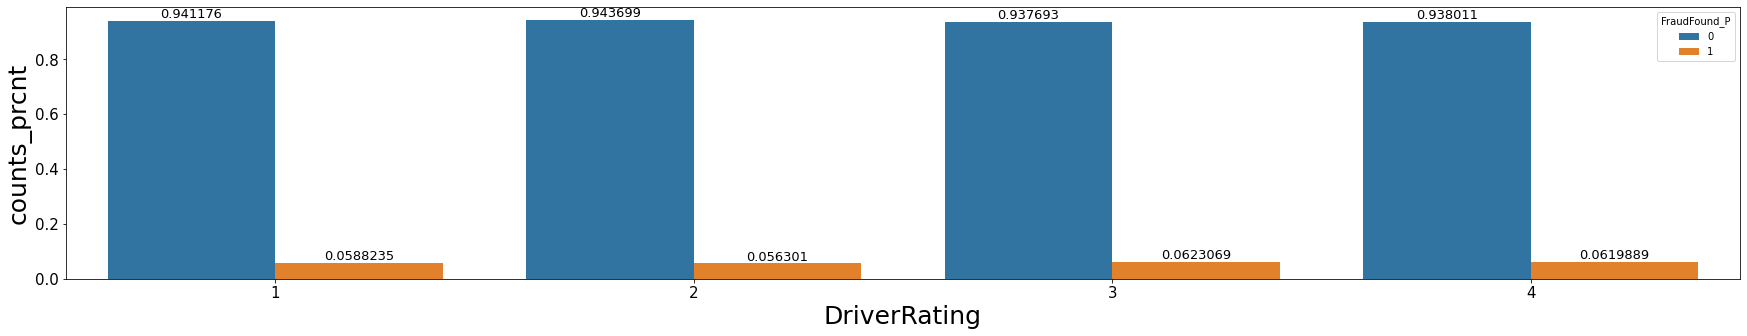

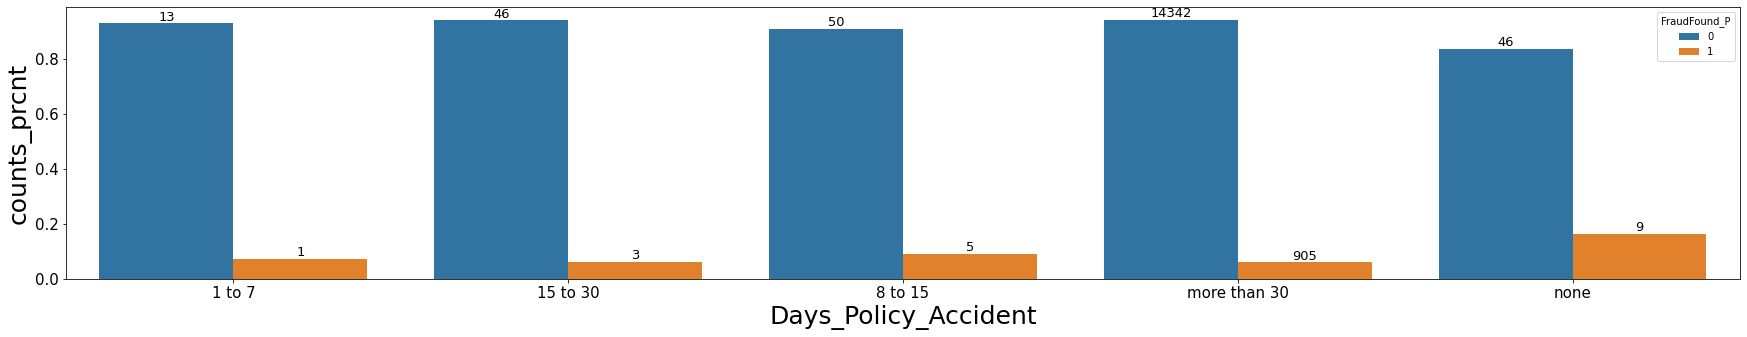

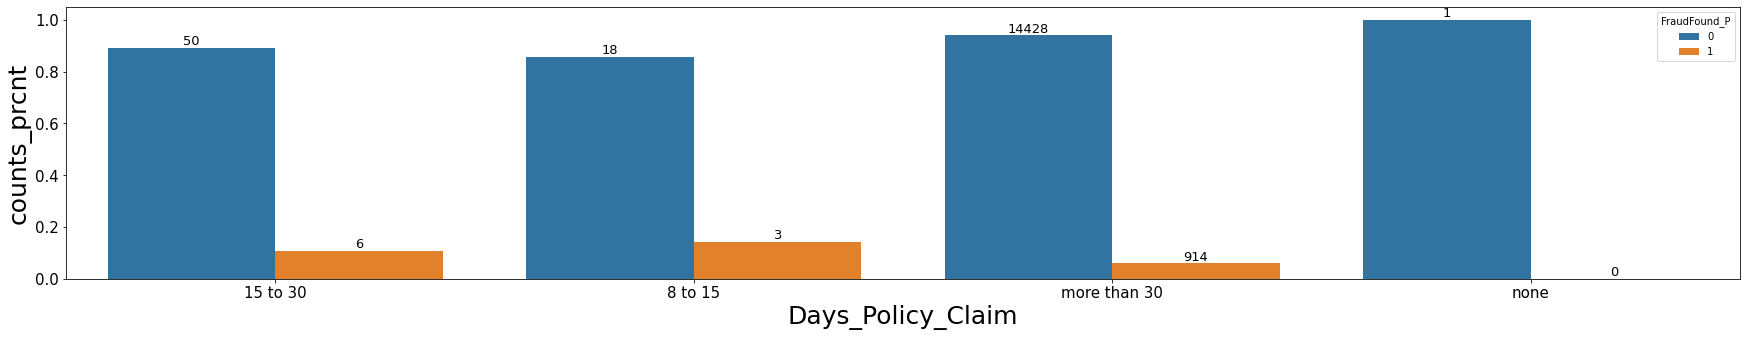

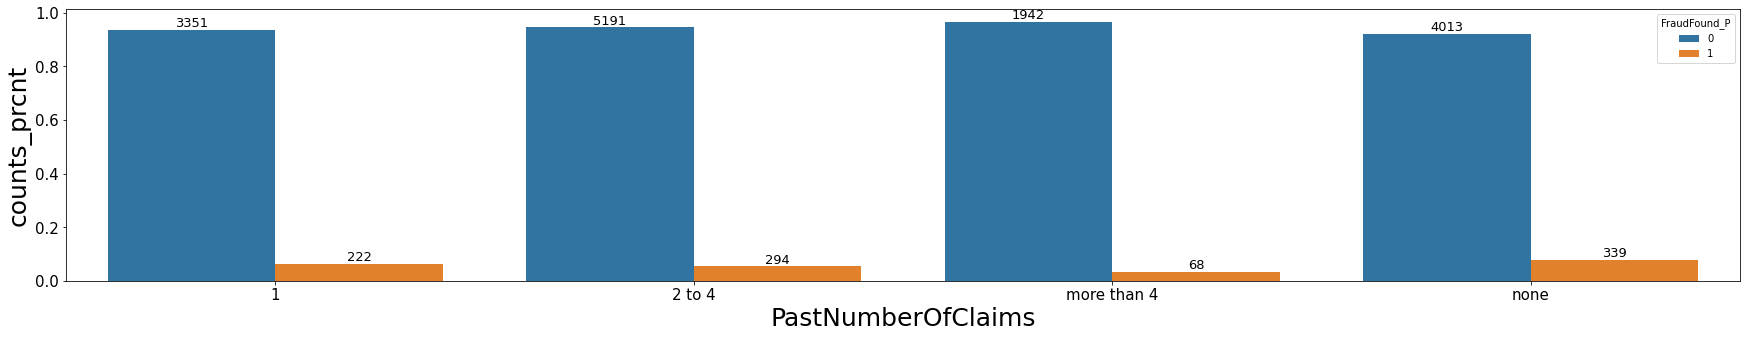

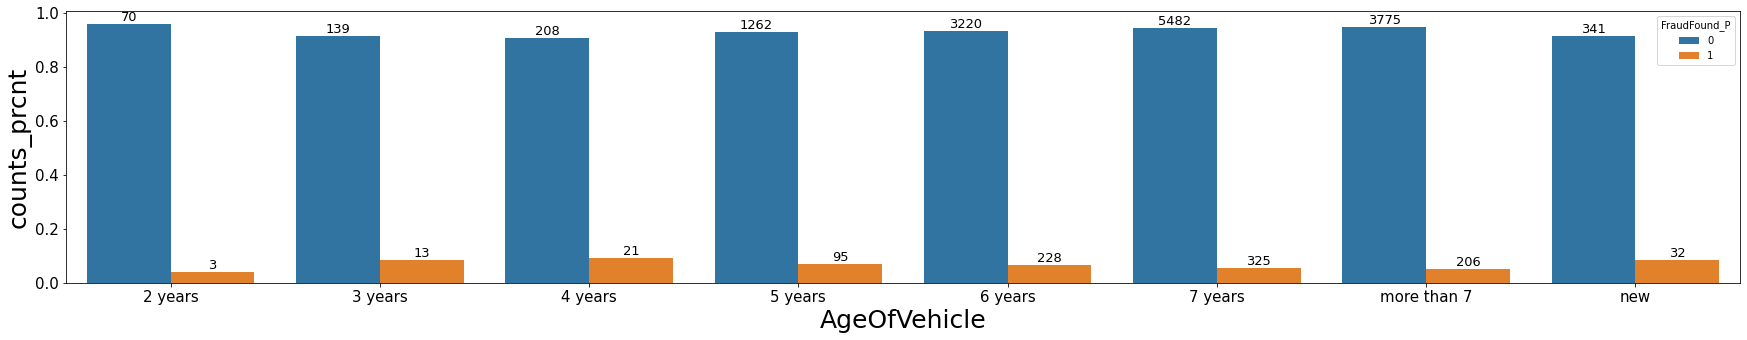

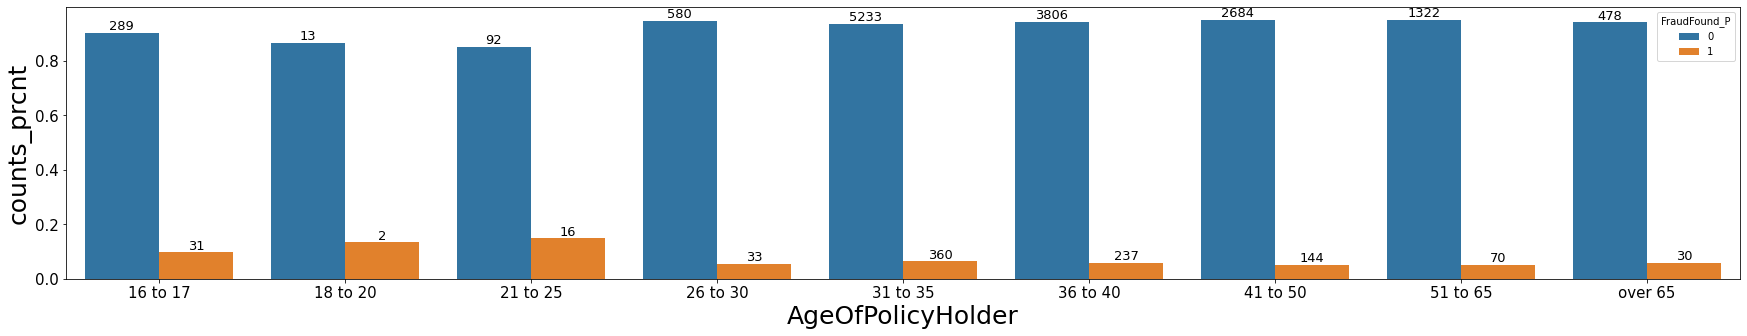

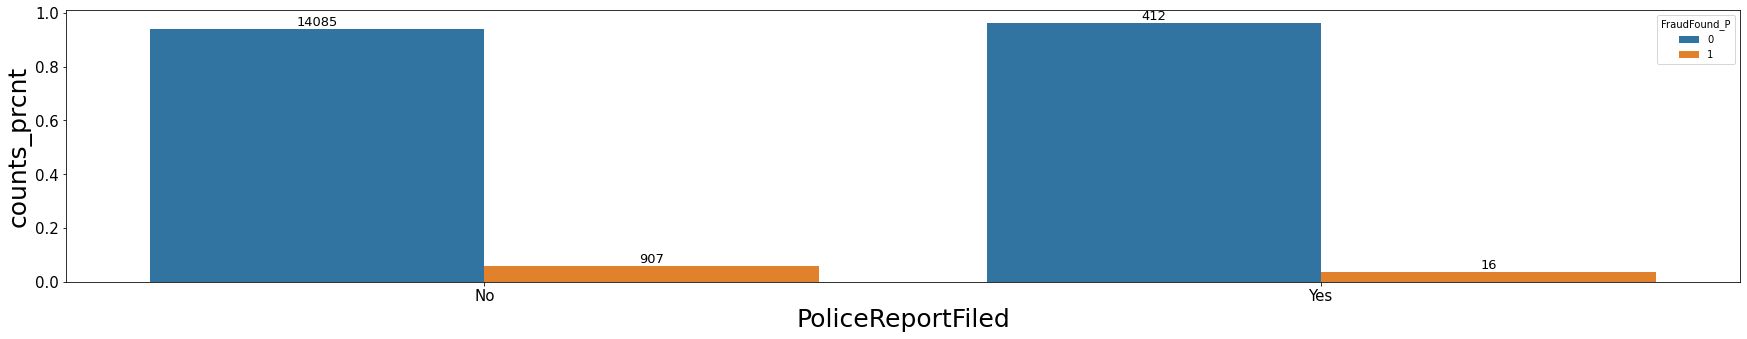

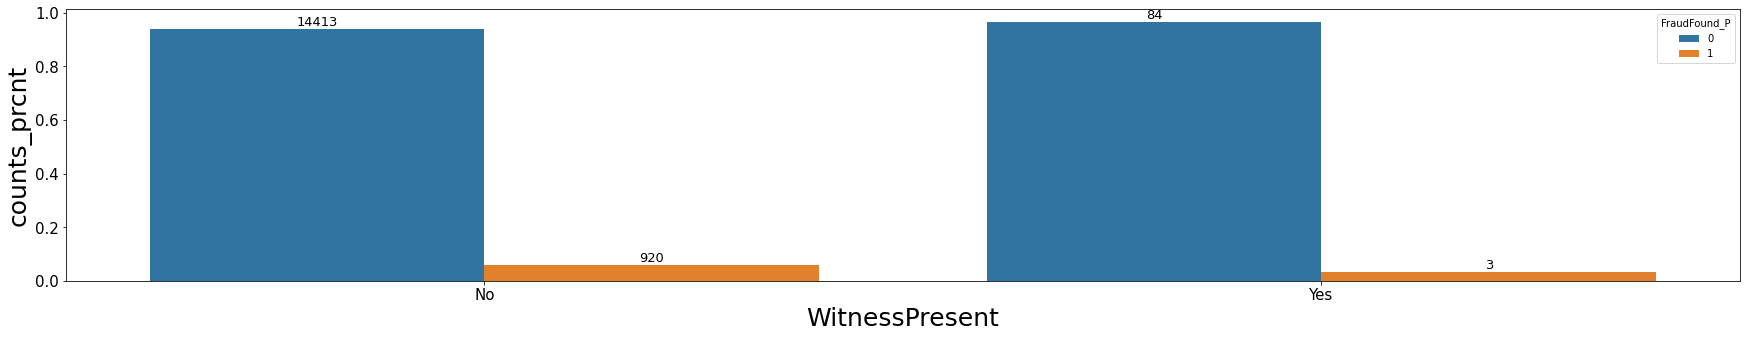

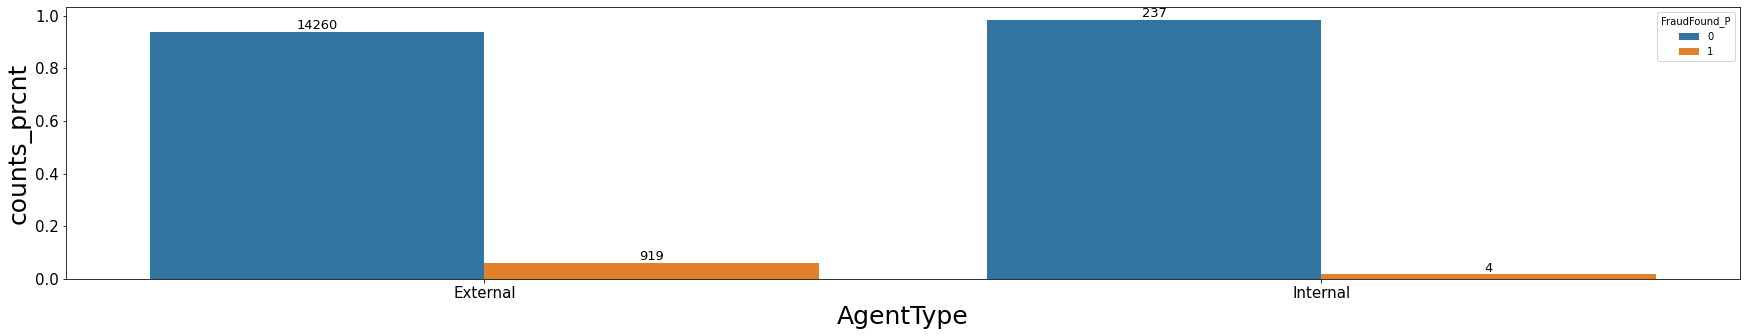

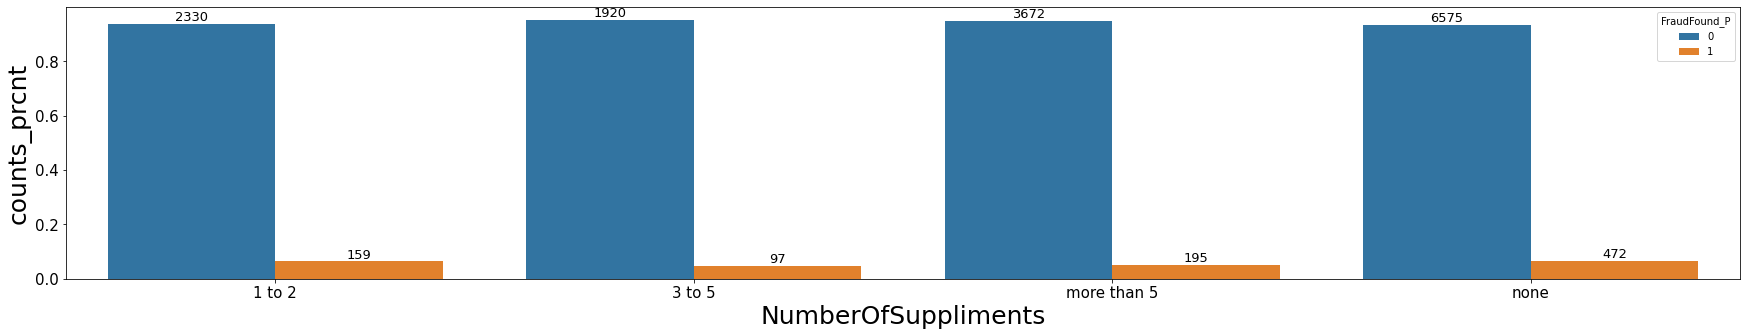

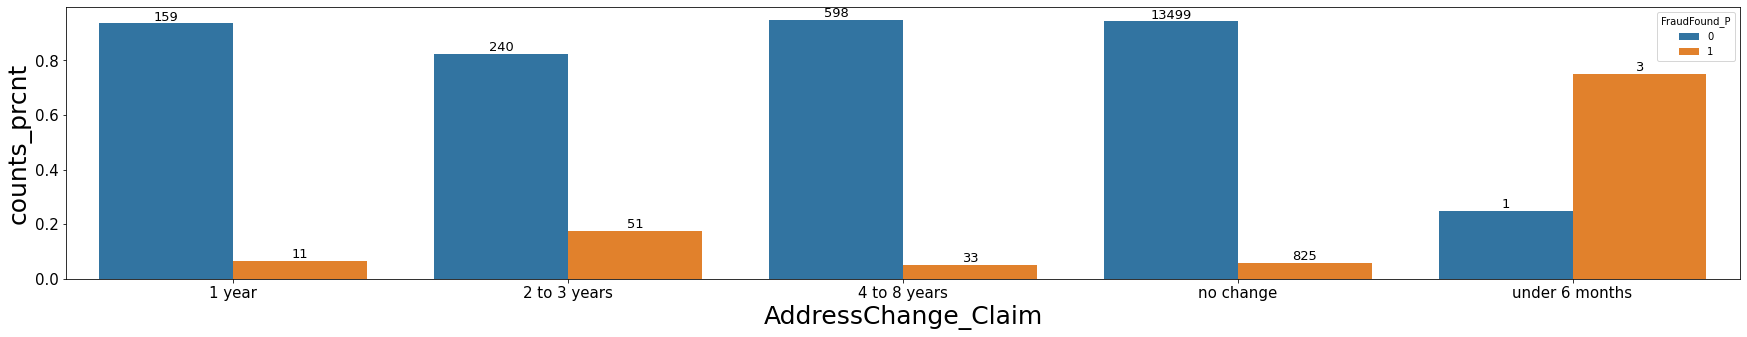

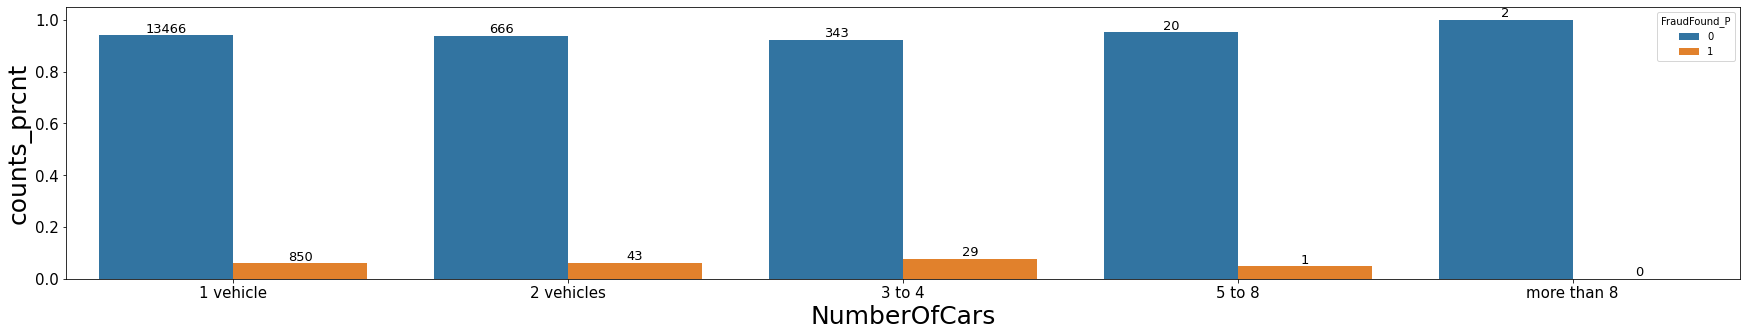

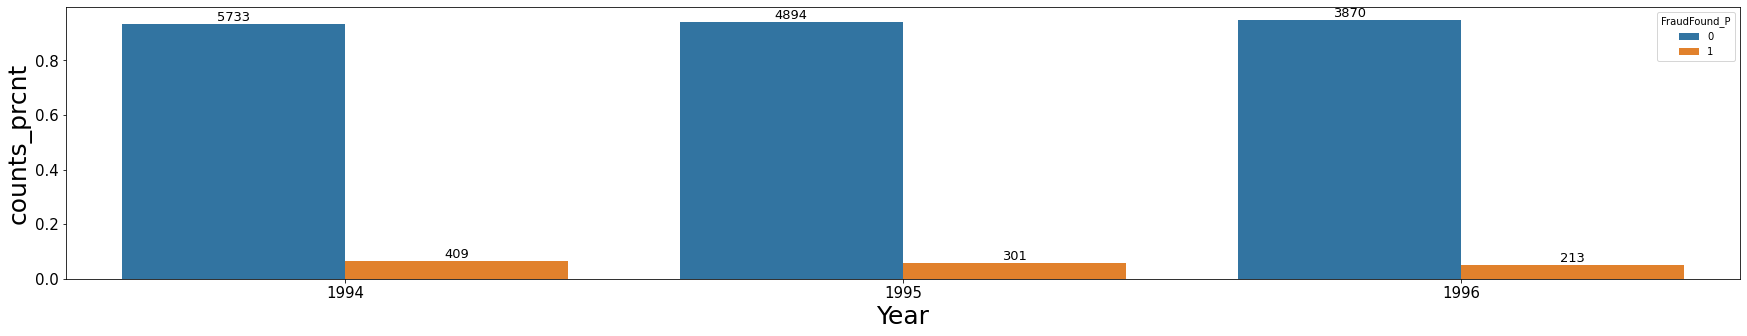

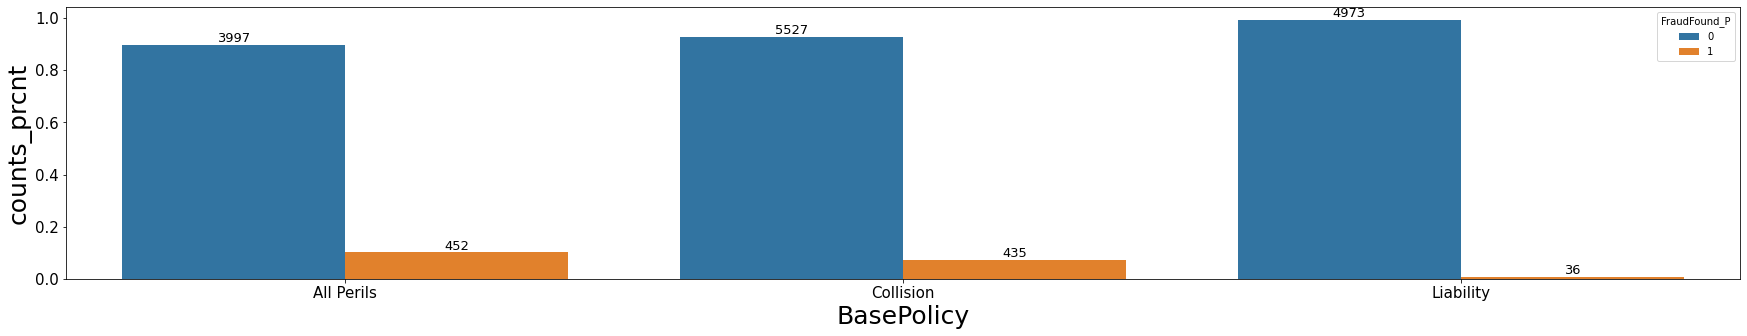

In [42]:
fraud_col = "FraudFound_P"

numerical_features = [
    'Age',
]

categorical_features = [
    "Month",
    "WeekOfMonth",
    "DayOfWeek", 
    "Make",
    "AccidentArea",
    "DayOfWeekClaimed",
    "MonthClaimed",
    "WeekOfMonthClaimed",
    "Sex",
    'MaritalStatus', 
    'Fault', 
    'PolicyType', 
    'VehicleCategory',
    'VehiclePrice',  
    'RepNumber',
    'DriverRating', 
    'Days_Policy_Accident',
    'Days_Policy_Claim', 
    'PastNumberOfClaims', 
    'AgeOfVehicle',
    'AgeOfPolicyHolder', 
    'PoliceReportFiled', 
    'WitnessPresent', 
    'AgentType',
    'NumberOfSuppliments',
    'AddressChange_Claim', 
    'NumberOfCars', 
    'Year',
    'BasePolicy'
]

for cat_col in categorical_features:
    dist_df_flat = generate_dist_fraud(df, fraud_col, cat_col, True)
    visualize_fraud_dist(dist_df_flat, fraud_col, cat_col)
    print("\n")

Text(0, 0.5, 'Counts Percentage')

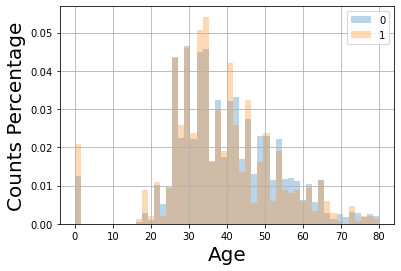

In [63]:
fig, ax = plt.subplots()
_ = df.groupby(fraud_col)["Age"].hist(density=True, alpha=0.3, ax=ax, legend=True, bins=50)
ax.set_xlabel("Age", size=20)
ax.set_ylabel("Counts Percentage", size=20)